https://journals.ametsoc.org/view/journals/atot/27/3/2009jtecho725_1.xml

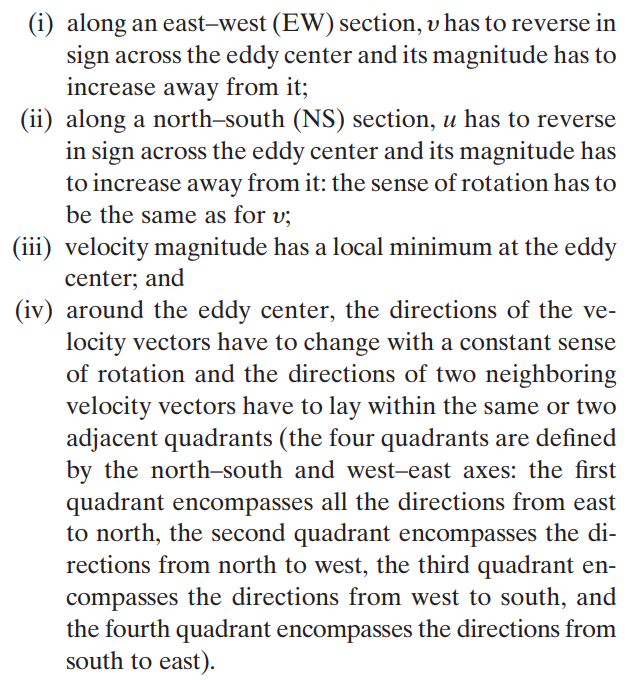

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

In [33]:
from scipy.io import netcdf_file
import os
# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file(os.path.join(os.path.abspath('') ,"data2.nc"))
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_u = f.variables['ugos'].data.squeeze()
vel_v = f.variables['vgos'].data.squeeze()


# fill in missing values
from common_functions import interpolate_missing_point

imputed_vel_u = interpolate_missing_point(vel_u, np.ma.masked_invalid(vel_u).mask)
imputed_vel_v = interpolate_missing_point(vel_v, np.ma.masked_invalid(vel_v).mask)

## Method Parameters:

In [3]:
a = 4
b = 3

## Constaint 3 

<IPython.core.display.Javascript object>


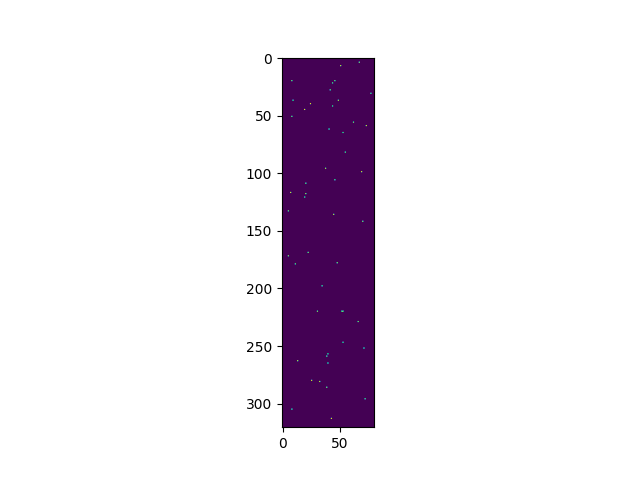

365


In [25]:
satifies_crit_3 = []

vel_magnitude = np.hypot(imputed_vel_u, imputed_vel_v)

for i, j in satifies_crit_2:
    try:
        local_min = np.argmin(vel_magnitude[i-b:i+b,j-b:j+b])
        shift = np.asarray(np.unravel_index(local_min, (2*b+1,2*b+1)))-b
    except ValueError:
        continue
    # check that the new points are there own local minima
    new_i = i + shift[0]
    new_j = j + shift[1]
    try:
        local_min = np.argmin(vel_magnitude[new_i-b:new_i+b,new_j-b:new_j+b])
        shift = np.asarray(np.unravel_index(local_min, (2*b+1,2*b+1)))-b
    except ValueError:
        continue
    if all(shift == 0):
        satifies_crit_3.append((i,j))

plt.figure()
tmp = np.zeros_like(change_of_sign_v)
tmp[tuple(np.transpose(satifies_crit_3))] = 1
plt.imshow(tmp)
print(len(satifies_crit_2))

<IPython.core.display.Javascript object>


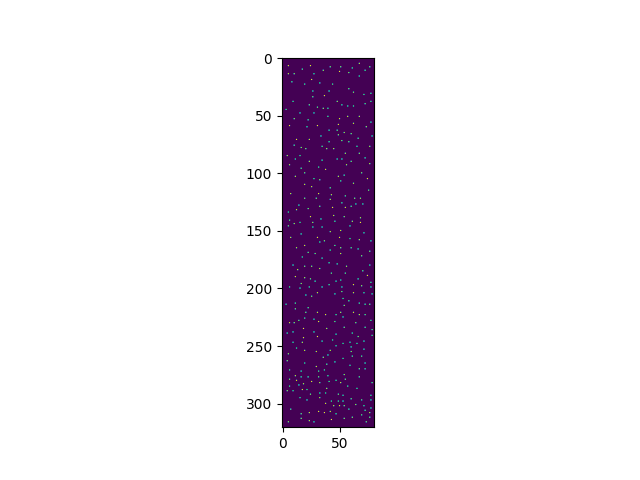

365


In [27]:
from skimage.feature import peak_local_max

vel_magnitude = np.hypot(imputed_vel_u, imputed_vel_v)

satifies_crit_3 = peak_local_max(-vel_magnitude, min_distance=b)

plt.figure()
tmp = np.zeros_like(change_of_sign_v)
tmp[tuple(np.transpose(satifies_crit_3))] = 1
plt.imshow(tmp)
print(len(satifies_crit_2))

## Constraint 1

<IPython.core.display.Javascript object>


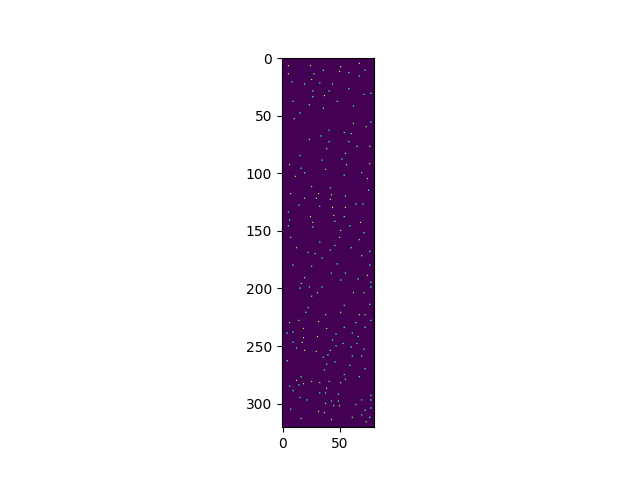

204


In [29]:
import math
sign = lambda x: math.copysign(1, x)

satifies_crit_1 = []
direction = []

change_of_sign_v = change_of_sign(imputed_vel_v)

for i,j in satifies_crit_3:
    center = imputed_vel_v[i,j]
    try:
        left = imputed_vel_v[i,j-a]
        right = imputed_vel_v[i,j+a]
    except IndexError:
        continue # point too close to the edge
    if abs(center) < abs(right) and abs(center) < abs(left) and sign(left)*sign(right) == -1:
        satifies_crit_1.append((i,j))
        direction.append(sign(left))

plt.figure()
tmp = np.zeros_like(change_of_sign_v)
tmp[tuple(np.transpose(satifies_crit_1))] = 1
plt.imshow(tmp)
print(len(satifies_crit_1))

## Constraint 2

<IPython.core.display.Javascript object>


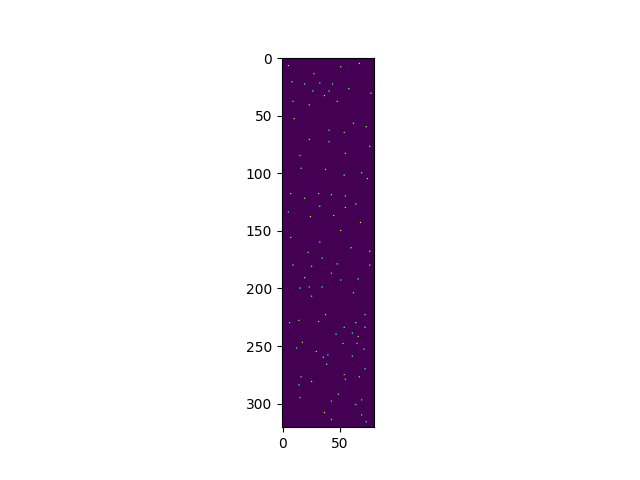

100


In [30]:
satifies_crit_2 = []

for (i, j), clockwise in zip(satifies_crit_1, direction):
    center = imputed_vel_u[i,j]
    try:
        bottom = imputed_vel_u[i-a, j]
        top = imputed_vel_u[i+a,j]
    except IndexError:
        continue # point to close to the edge
    if abs(center) < abs(bottom) and abs(center) < abs(top) and sign(bottom)*sign(top) == -1 and clockwise == sign(top):
        satifies_crit_2.append((i,j))

plt.figure()
tmp = np.zeros_like(change_of_sign_v)
tmp[tuple(np.transpose(satifies_crit_2))] = 1
plt.imshow(tmp)
print(len(satifies_crit_2))

## Constraint 4